<h1> Dhaka air quality </h1>

This project aims to analyse the air quality data for Dhaka city since 2016.

The data is collected from the US Embassy in Dhaka, which records hourly air quality measurements using a monitor on their roof. Their instrument measures the average concentration of fine particle pollutants (PM2.5) in the air over an hour and converts this into an Air Quality Index (AQI) value. AQI is a numerical scale, between 0 and 500, informing how potentially dangerous the air is to health, where small numbers are good and large numbers are bad.

The recognised acceptable standard for AQI is up to 100, once the quality of air degrades to an AQI above 100, sensitive groups of people may experience adverse health effects. AQI values above 150 are considered "unhealthy", meaning everyone begins to be at risk of adverse health issues, the severity of which increases as the AQI gets larger -- with air deemed "very unhealthy" at AQI in excess of 200 and "extremely unhealthy" above 300.

<h2> Analysis and Visualisation </h2>

This notebook imports the cleaned data from the "pre-processing" notebook. Various investiagtions are made, such as time-series analysis looking for seasonal variation and time of day variations, whether statistically the overall air quality situation has changed since 2016, whether Covid-19 lockdowns had any discernable affects, etc.

In [89]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta 
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib as mpl


<h2> Data import </h2>

In [3]:
datapath = Path('../data/')
df = pd.read_csv(f'{datapath}/clean_data.csv')

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35760 entries, 2016-03-01 03:00:00 to 2020-08-02 00:00:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     35760 non-null  int64         
 1   Site           35760 non-null  object        
 2   Parameter      35760 non-null  object        
 3   Year           35760 non-null  int64         
 4   Month          35760 non-null  int64         
 5   Day            35760 non-null  int64         
 6   Hour           35760 non-null  int64         
 7   NowCast Conc.  35760 non-null  float64       
 8   AQI            35760 non-null  int64         
 9   AQI Category   35760 non-null  object        
 10  Raw Conc.      35760 non-null  float64       
 11  Conc. Unit     35760 non-null  object        
 12  Duration       35760 non-null  object        
 13  QC Name        35760 non-null  object        
 14  Date           35760 non-null  datetime64[n

In [12]:
df.head()

,Unnamed: 0,Site,Parameter,Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name,Date
Date,,,,,,,,,,,,,,,
2016-03-01 03:00:00,1442,Dhaka,PM2.5 - Principal,2016,3,1,3,251.4,302,Hazardous,289.0,UG/M3,1 Hr,Valid,2016-03-01 03:00:00
2016-03-01 04:00:00,1443,Dhaka,PM2.5 - Principal,2016,3,1,4,246.0,296,Very Unhealthy,240.0,UG/M3,1 Hr,Valid,2016-03-01 04:00:00
2016-03-01 05:00:00,1444,Dhaka,PM2.5 - Principal,2016,3,1,5,264.0,314,Hazardous,290.0,UG/M3,1 Hr,Valid,2016-03-01 05:00:00
2016-03-01 06:00:00,1445,Dhaka,PM2.5 - Principal,2016,3,1,6,256.8,307,Hazardous,245.0,UG/M3,1 Hr,Valid,2016-03-01 06:00:00
2016-03-01 07:00:00,1446,Dhaka,PM2.5 - Principal,2016,3,1,7,238.2,288,Very Unhealthy,205.0,UG/M3,1 Hr,Valid,2016-03-01 07:00:00


<h2>Quick exploration</h2>

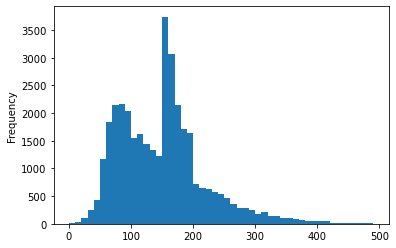

In [87]:
df['AQI'].plot(kind='hist', bins=range(0,500,10))

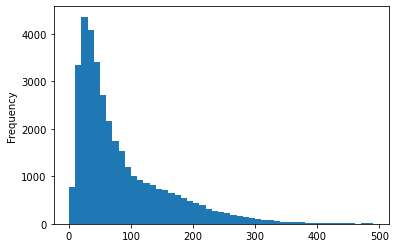

In [8]:
df['Raw Conc.'].plot(kind='hist', bins=range(0,500,10))

In [31]:
df['AQI Category'].value_counts(normalize=True)

Unhealthy                         0.343876
Moderate                          0.263479
Unhealthy for Sensitive Groups    0.199609
Very Unhealthy                    0.131152
Hazardous                         0.036605
Good                              0.025280
Name: AQI Category, dtype: float64

In [60]:
def time_resample(dataframe, time_period):
    '''
    Resamples the dataframe over the given period of time. 
    For example, if values averaged over a day required then arguments would be df and "D"
    
    >> time_period: 'D' = days, 'M' = month, 'Y' = year

    Returns dataframe object
    '''
    dataframe.index = dataframe.Date
    resampled_df = pd.DataFrame()
    resampled_df['AQImean'] = dataframe.AQI.resample(time_period).mean()
    resampled_df['AQImed'] = dataframe.AQI.resample(time_period).median()
    resampled_df['AQImin'] = dataframe.AQI.resample(time_period).min()
    resampled_df['AQImax'] = dataframe.AQI.resample(time_period).max()
    resampled_df['AQIstd'] = dataframe.AQI.resample(time_period).std()
    resampled_df['Date'] = dataframe.Date.resample(time_period).first()
    resampled_df['Month'] = dataframe.Month.resample(time_period).first()
    resampled_df['Year'] = dataframe.Year.resample(time_period).first()
    resampled_df['Day'] = dataframe.Day.resample(time_period).first()
    #  To ensure statistical significance want to omit values when a significant fraction of the
    #  expected number of measurements in the given time period are missing. 
    #  For example, days when only 5 hours in 24 have measurement data available.
    #  Lets exclude data where half the expected measurements missing:
    resampled_df['Measurements'] = dataframe.AQI.resample(time_period).count()
    resampled_df = resampled_df[resampled_df['Measurements']>resampled_df['Measurements'].max()/2]
    return resampled_df

In [57]:
df_dayavg = time_resample(df, 'D')
df_monthavg = time_resample(df, 'M')

Text(0.5, 1.0, 'Distribution of Daily Average AQI')

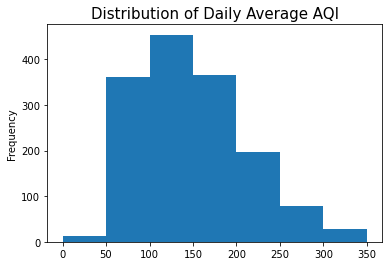

In [85]:
df_dayavg.AQImean.plot(kind='hist', bins=range(0,400,50))
plt.title('Distribution of Daily Average AQI', fontsize=15)

Text(0.5, 1.0, 'Distribution of Monthly Average AQI')

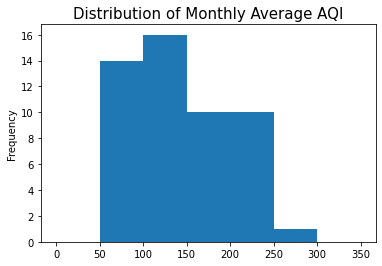

In [84]:
df_monthavg.AQImean.plot(kind='hist', bins=range(0,400,50))
plt.title('Distribution of Monthly Average AQI', fontsize=15)

<h2> AQI Categories Explained </h2>

The AQI is divided in six categories and each category is meant to correspond to different health concern levels. Below is an explanation of the categories and their meanings.

    0 – 50 indicates “Good” AQI. At this level the quality of air is deemed to be satisfactory, and air pollution poses little or no risk.

    51 – 100 indicate “Moderate” AQI. This means acceptable Air quality. However, some pollutants might arouse modest health concern for a limited number of people. For instance, persons who are remarkably sensitive to ozone may experience respiratory symptoms.

    101 – 150 indicate “Unhealthy for Sensitive Groups” AQI. This category may not be able to affect the general health of the public. However, children, older adults, and persons with lung disease are at a greater risk from ozone exposure. Older children, adults and people with lung and heart disease are at greater risk from exposure to particulate matter.

    151 – 200 indicate “Unhealthy” AQI. In this category, every person might experience some adverse health effects. Sensitive group members may experience more serious effects. People with heart or lung disease, older adults and children should cut back or reschedule strenuous activities.

    201 – 300 indicate “Very Unhealthy” AQI. This would issue a health alert to mean that everybody may experience very serious health implications. People with heart or lung disease, older adults and children should significantly cut back or reschedule strenuous activities.

    Greater than 300 indicate “Hazardous” AQI. Air quality at this level is life-threatening and would issue warnings of emergency conditions for the entire population.


<h2> Seasonal Variation in the AQI </h2>

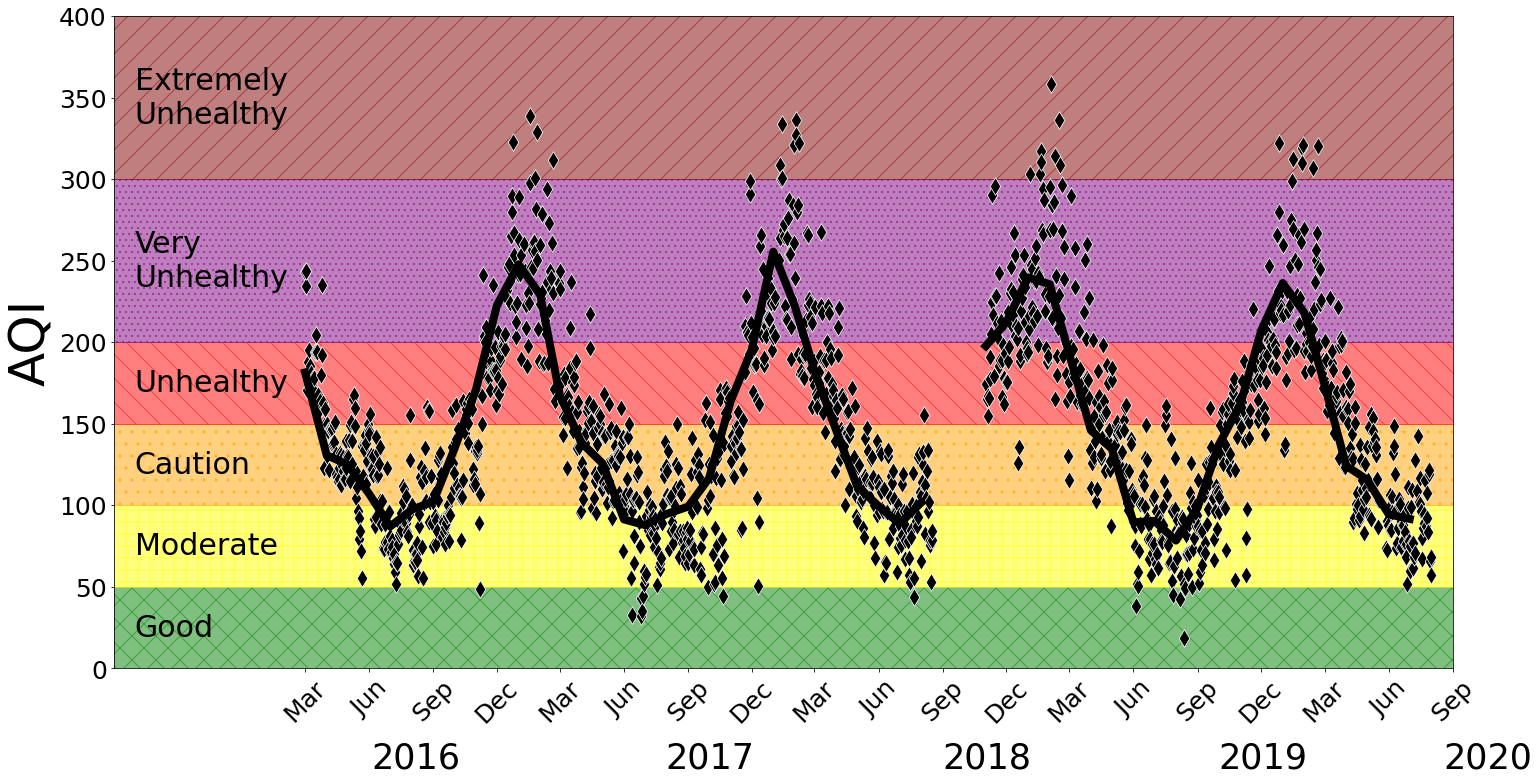

In [74]:
fig, ax = plt.subplots(figsize=(24,12))
a
trans = 0.5
xpoints = [datetime.strptime('2015-01-01', "%Y-%m-%d"), datetime.strptime('2020-12-01', "%Y-%m-%d")]
plt.fill_between(x = xpoints, y1 = 0, y2 = 50 , color = 'green', alpha = trans, hatch = 'x')
plt.fill_between(x = xpoints, y1 = 50, y2 = 100 , color = 'yellow', alpha = trans, hatch = '+')
plt.fill_between(x = xpoints, y1 = 100, y2 = 150 , color = 'orange', alpha = trans, hatch = '.')
plt.fill_between(x = xpoints, y1 = 150, y2 = 200 , color = 'red', alpha = trans, hatch = '\\')
plt.fill_between(x = xpoints, y1 = 200, y2 = 300 , color = 'purple', alpha = trans, hatch = '..')
plt.fill_between(x = xpoints, y1 = 300, y2 = 500 , color = 'maroon', alpha = trans, hatch = '/')

sns.scatterplot(x='Date',  y='AQImean', data = df_dayavg, color = 'k', s = 155, marker = 'd')#, #legend = False,
sns.lineplot(x='Date',  y='AQImean', data = df_monthavg[df_monthavg['Date']<'2018-08-17'], color = 'k', lw = 8)#, #legend = False,
sns.lineplot(x='Date',  y='AQImean', data = df_monthavg[df_monthavg['Date']>'2018-11-01'], color = 'k', lw = 8)#, #legend = False,

textsize = 35
years = ['2016', '2017', '2018', '2019', '2020']
axis_positions = [0.3, 0.47, 0.63, 0.79, 0.92]
for xpos, year in zip(axis_positions, years):
    plt.figtext(xpos, 0.01, year, ha = 'center', fontsize = textsize)

quality_categories = ['Good', 'Moderate', 'Caution', 'Unhealthy', 'Very\nUnhealthy', 'Extremely\nUnhealthy']
y_positions = [25, 75, 125, 175, 250, 350]
textsize = 30
textstartdate = datetime.strptime('2015-07-01', "%Y-%m-%d")
for y_pos, category in zip(y_positions, quality_categories):
    plt.text(textstartdate, y_pos, category, va = 'center', fontsize = textsize)
    
plt.xticks([*map(lambda x: datetime.strptime(x, "%Y-%m"), ['2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06', '2017-09', 
             '2017-12','2018-03', '2018-06', '2018-09', '2018-12', '2019-03', '2019-06', 
             '2019-09', '2019-12', '2020-03', '2020-06', '2020-09'])], rotation = 45, fontsize = 25)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.yticks(fontsize = 25)
plt.ylim(0,400)
plt.xlim(datetime.strptime('2015-06-01', "%Y-%m-%d"), datetime.strptime('2020-09-01', "%Y-%m-%d"))
plt.ylabel('AQI', fontsize =50)
plt.xlabel('')

plt.savefig('../report/AQImean.png', bbox_inches='tight')

<h2> Time of day variations </h2>

This section explores how the air quality varies over the day. Since there is a strong link between air quality, air movement and temperatures (dictated by the physics of gases and variations of pressure with temperature) and there is clearly seasonal variations in temperatures and daylight hours we need to consider the seasonal time of year too in this section. 

With this in mind I have created a heatmap of the AQI values as function of hour of the day and month of the year:

In [100]:
#  Create custom colour bar to match the standard AQI categories colour scheme

norm = mpl.colors.Normalize(-1,1)
aqicolors = [[0, 'green'], [55/350, 'yellow'], [75/350, 'yellow'], [105/350, 'orange'], [125/350, 'orange'], 
             [155/350, 'red'], [175/350, 'red'],[205/350, 'purple'], [275/350, 'purple'],[1, 'maroon']]
aqicmap = mpl.colors.LinearSegmentedColormap.from_list("", aqicolors)

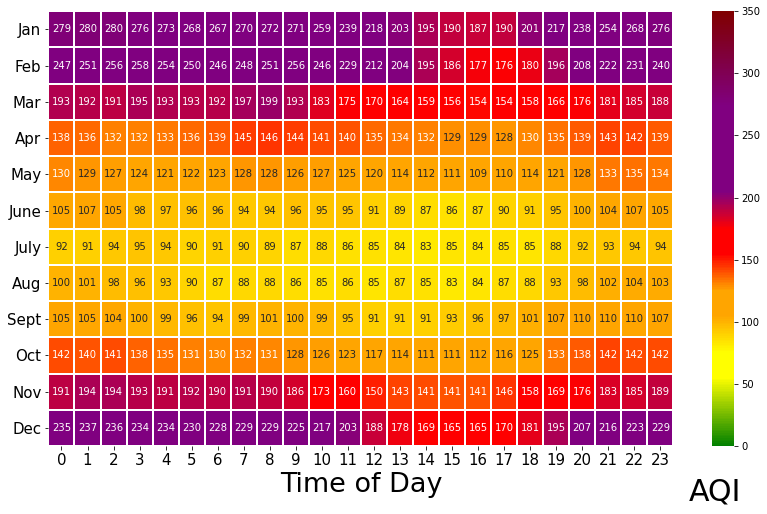

In [101]:
plt.figure(figsize=(14,8))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
seasonaltable = df.pivot_table(values='AQI',index='Month',columns='Hour')
sns.heatmap(seasonaltable, cmap=aqicmap,linecolor='white',
            linewidths=1, yticklabels = months, vmin = 0, vmax = 350, annot = True, fmt = '.0f')
plt.ylabel('')
plt.xlabel('Time of Day', fontsize = 27)
plt.yticks(rotation = 0, fontsize = 15)
plt.xticks(fontsize=15)
plt.figtext(0.76,0.03,'AQI', fontsize = 30)
plt.savefig('../report/Heatmap_AQIcols.png', bbox_inches='tight')
plt.show()

Clearly there is variation of the air quality with respect to time of day. Counter-intuitively the air quality is better during the daylight hours of apprxoimately 10 AM to 6 PM despite increased traffic on the roads at this time. This is due to meterologoical effects whereby the hotter it is the more effectively pollutants can be dispersed into the upper atmosphere. 

The seasonal variation shown previously is also clear in this plot. The (western) summer months of June to September, which is monsoon season here, has the best air quality. The winter months generally have the worst air quality and, because at this time of year their are the largest swings in temperature between day and night, we see the largest variations in AQI across a typical day too. 